## DIRECT: Spatial Nonstationarity Phenomenon, Evaluation, and Mitigation 


#### Lei Liu, Graduate Research Assistant, University of Texas at Austin
#### Masa Prodanovic, Professor, University of Texas at Austin
#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

This workflow demonstrate how to model spatial nonstationary phenomenon, the impacts of such phenomenon on deep learning (Convolutional Neural Network) predictions, the mitigation solutions using Vision Transformers.

Steps:
1. model stationary realizations and 2 common types of spatial nonstationary realizations through Sequential Gaussian Simulation (SGS)
2. Train a CNN model using stationary realiztaions to predict their variogram ranges.
3. Simiary, train a Transformer model on stationary realizations.
4. Predict variogram ranges of nonstationary realizations using well-trained models.

Import some standard packages

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import math
import geostatspy
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf                                 # import tensor flow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [2]:
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,):

    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )
    im = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)    
    plt.scatter(
        df[xcol],
        df[ycol],
        s=None,
        c=df[vcol],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        verts=None,
        edgecolors="black",
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation="vertical")
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im

#### Unconditional Sequential Gaussian Simulation
Let's make a dummy data set with a parametric distribution; the input data in calculated through SGS.

In [5]:
X_uncon = np.full(1000,-999999.9)
Y_uncon = np.full(1000,-999999.9)
Por = np.random.normal(loc = 0.15,scale = 0.03,size=1000)  

df = pd.DataFrame({'X':X_uncon,'Y':Y_uncon,'Por':Por})
df.head()

,X,Y,Por
0,-999999.9,-999999.9,0.115262
1,-999999.9,-999999.9,0.135565
2,-999999.9,-999999.9,0.165453
3,-999999.9,-999999.9,0.121576
4,-999999.9,-999999.9,0.119769


c:\users\leili\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

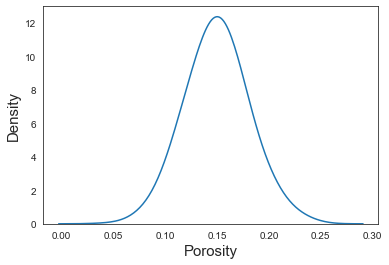

In [6]:
import seaborn as sns
sns.set_style(style='white')
sns.kdeplot(df['Por'], bw=0.5)
plt.xlabel('Porosity', fontsize=15)
plt.ylabel('Density', fontsize=15)

#### Sequential Gaussian simulation
* hmaj - the range for this nested structure in the major direction
* hmin - the range for this nested structure in the minor direction
* nug - nugget effect contribution to sill
* nst - number of nested structures (1 or 2)
* it - type for this nested structure (1 - spherical, 2 - exponential, 3 - Gaussian)
* cc - contribution of each nested structure (contributions + nugget must sum to the sill)
* azi - the azimuth for this nested structure of the major direction, the minor is orthogonal


 Data for SGSIM: Number of acceptable data     = 1000
                 Number trimmed                = 0
                 Weighted Average              = 0.1499
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9987
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 25088
Reassigning data to nodes

 Realization 0: number   = 50176
                                   mean     = -0.0509 (close to 0.0?)
                                   variance = 0.7348 (close to gammabar(V,V)? approx. 1.0)


c:\users\leili\appdata\local\programs\python\python39\lib\site-packages\geostatspy\GSLIB.py:700: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  plt.scatter(


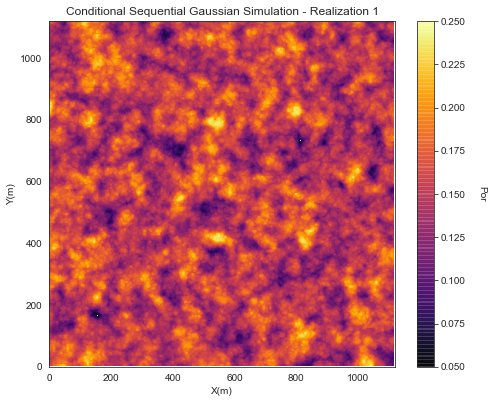

In [11]:
# SGSIM parameters setting
nx = 224; ny = 224; #number of cells
xsiz = 5.0; ysiz = 5.0; #cell size
xmn = xsiz/2; ymn = ysiz/2; # grid origin, location center of lower left cell

#basic indicator kriging parameters
ndmin = 0; ndmax = 20; # minimum and maximum data for kriging 
radius = 1000; # maximum search distance
ktype = 1; # kriging type, 0 - simple, 1 - ordinary
skmean = 0  
tmin = -999; tmax = 999  # data trimming limits

#check one realization first
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)
sim = geostats.sgsim(df,'X','Y','Por',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
            zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73085,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=1,colocorr=0.0,sec_map=0,vario=vario)


xmin = 0.0; xmax = nx*xsiz; ymin = 0.0; ymax = ny*ysiz; 
cmap = plt.cm.inferno #color map

GSLIB.pixelplt(sim,xmin,xmax,ymin,ymax,xsiz,0,0.3,'range=100','X','Y','Por',cmap,'range=100')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)

#### Training data & Testing data

* Following above method, we make a series of realiztaions with different variogram ranges
* We observe that realitaions tend to be more nonstationary with increasing ranges. Around 1/3 of spatial extent, it tends to be nonstationary.
* Hence, we make a series of stationary realiztaions with variogram ranges less than 1/3 of spatial extent, which is our training set.
Note: Here we omit the procedures of calculating the training set. The training data and also testing data is attached.

#### Testing data
* here we discuss two common types of spatial nonstationarity. 
* The first one is large relative variogram rangerelated nonstationarity. That is to say, it tends to be stationay globally but may be nonstationary locally. To calculate such realizations, just make variogram ranges larger than 1/3 of spatial size.
* The second one is additive trend and residual model-related nonstationarity. We add a linear trend to a stationary realization to calculate such realization (see below for an example).

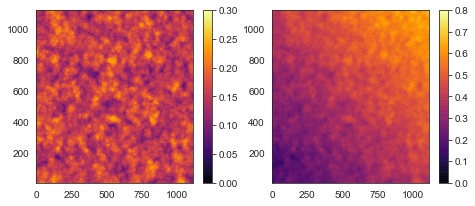

In [22]:
from scipy.ndimage import rotate
x = np.linspace(0,0.25,224)
xx, yy = np.flip(np.meshgrid(x,x))
trend = xx+yy
trend= rotate(trend,270,reshape=True)

#plot
cmap = plt.cm.inferno
plt.subplot(121) #stationary realization with range 100m
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,xsiz,0,0.3,'','','','',cmap)

plt.subplot(122) # a linear trend + stationary realization
GSLIB.pixelplt_st(sim+trend,xmin,xmax,ymin,ymax,xsiz,0,0.8,'','','','',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=0.6, wspace=0.2, hspace=0.3)

In [ ]:
# here is the stationary data
x = np.load('224cellsX.npy') #(3000, 224, 224, 1) #1220m
y = np.load('224cellsY.npy') #(3000) max 400m

# here is the type I nonstationary data
x224 = np.load('224cellsX_nonsta.npy')
y224 = np.load('224cellsY_nonsta.npy')

### CNN model for predicting the range

In [23]:
from tensorflow.keras.models import Sequential
def CNN_model(lr=1e-6, decay = 1e-4):
    # define neural network model sequentially
    model = Sequential()   
    # Feature map 1
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, input_shape=[nx,ny,1], padding="same"))  #Lei: padding=same:the center of the kernel should be on the grid, which means the output size is the same as input size.
    model.add(layers.ReLU())
    
    # Feature map 2
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    
    # Feature map 3
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2))
       
    # Feature map 4
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation = 'linear'))   

    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    opt = keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8, decay=decay)
    model.compile(loss='mse', metrics=['mae','mape'],  optimizer='adam') #'adam'-> rmsprop #optimizer='adam'
    return model

In [24]:
model = CNN_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0

train model and check performance

In [ ]:
#Min/Max scaler
X_ss = (X-X.min())/(X.max()-X.min())
Y_ss = y/400;

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_ss, Y_ss, test_size=0.3, random_state=0,shuffle=True) # try use raw X value

#reshape data
Y_train = Y_train.reshape(Y_train.shape[0],-1)  
Y_test = Y_test.reshape(Y_test.shape[0],-1)  

X_train = X_train[:,:,:].reshape([X_train.shape[0],nx,ny,-1])
X_test = X_test[:,:,:,].reshape([X_test.shape[0],nx,ny,-1])

In [25]:
nepoch = 300; batch_size = 32                 
model = CNN_model()
es = tf.keras.callbacks.EarlyStopping(min_delta = 0.0, monitor='val_loss', patience=50)

history = model.fit(X_train,  Y_train, 
                     batch_size=batch_size, epochs=nepoch, verbose=2, 
                     validation_data=(X_test, Y_test),shuffle=True)

NameError: name 'X_train' is not defined

In [ ]:
def model_performance(history,nepoch):  # visualize error and loss, training and testing over Epochs     
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_loss'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Loss --- MSE',fontsize=15)
    plt.ylabel('Loss',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,0.01])
    
    plt.subplot(1,3,2)
    plt.plot(history.history['mae'],c='red')
    plt.plot(history.history['val_mae'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Metrics --- MAE',fontsize=15)
    plt.ylabel('Metrics-MAE',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,0.1])
    
    plt.subplot(1,3,3)
    plt.plot(history.history['mape'],c='red')
    plt.plot(history.history['val_mape'],c='black')
    plt.tick_params(labelsize=12)
    plt.title('CNN Model Metrics --- MAPE',fontsize=15)
    plt.ylabel('Metrics-MAPE',fontsize=15); plt.xlabel('Epoch',fontsize=15); plt.grid()
    plt.legend(['training', 'validation'], loc='upper right',fontsize=15); plt.xlim([0,nepoch]); plt.ylim([0,50])
    
    plt.subplots_adjust(left=0.5, bottom=0.0, right=3.0, top=1.0, wspace=0.25, hspace=0.3)    
    plt.show()

In [ ]:
model_performance(history,nepoch)  

### ViT model 

In [ ]:
from ViT import ViT
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import time

In [ ]:
class Mydata(Dataset):
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        return image, label
    
    def __len__(self):
        return len(self.data)

dataset = Mydata(X_ss,Y_ss)

In [ ]:
train_size = int(0.7*len(dataset))
test_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, test_size]) #train_set:2100; val_set:900

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True) #2100/32 = 66
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)     #900/32 = 29

train_features, train_labels = next(iter(train_dataloader))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(
            image_size = 224,
            patch_size = 8,
            num_classes = 1,
            dim = 32, #768before
            depth = 6,
            heads = 3,
            mlp_dim = 128, #800before
            dropout = 0.0,
            emb_dropout = 0.0
            )
model.to(device)

In [ ]:
#define loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()

#define optimizer
lr = 1e-6
optimizer = torch.optim.Adam(model.parameters(),lr=lr, eps=1e-8, weight_decay=1e-4)

#traiing parameters
total_train_step = 0
total_val_step = 0
epoch = 300

start_time = time.time()
for i in range(epoch):
    print('----------This is the {} epoch training---------'.format(i+1))
    train_loss = 0
    
    model.train()
    for imgs, labels in train_dataloader: #for 1 epoch, 66 steps are needed (train data/ batch size)    
        imgs, labels = imgs.to(device), labels.to(device)          
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        #optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #update weights 
        total_train_step = total_train_step + 1 #step means iteration, 1 iter means train the number of (batch size) samples 
        train_loss += loss.item()
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            total_val_loss = total_val_loss + loss.item()   
            total_val_step += 1     
    print('total val loss:{}'.format(total_val_loss))

### SwinT model

In [ ]:
from swinT import SwinTransformer

In [ ]:
swin = SwinTransformer(
    hidden_dim=96,
    layers=(2,2,6,2),
    heads=(3,6,12,24),
    channels=1,
    num_classes=1,
    head_dim=16,
    window_size=5,
    downscaling_factors=(2,1,1,1),
    relative_pos_embedding=True)    
swin.to(device)

In [ ]:
#define loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()

#define optimizer
lr = 1e-6
optimizer = torch.optim.Adam(swin.parameters(),lr=lr, eps=1e-8, weight_decay=1e-4)

#traiing parameters
total_train_step = 0
total_val_step = 0
epoch = 300

start_time = time.time()
for i in range(epoch):
    print('----------This is the {} epoch training---------'.format(i+1))
    train_loss = 0    
    swin.train()
    for imgs, labels in train_dataloader: #for 1 epoch, 66 steps are needed (train data/ batch size)
        imgs, labels = imgs.to(device), labels.to(device)     
        outputs = swin(imgs)
        loss = loss_fn(outputs, labels)
        #optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #update weights
        total_train_step = total_train_step + 1 #step means iteration, 1 iter means train the number of (batch size) samples  
        train_loss += loss.item()    
    swin.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = swin(imgs)
            loss = loss_fn(outputs, labels)
            total_val_loss = total_val_loss + loss.item() 
            total_val_step += 1 
    print('total val loss:{}'.format(total_val_loss))

#### apply the model on nonstationary data

In [26]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [ ]:
x224 = np.load('224cellsX_nonsta.npy')
y224 = np.load('224cellsY_nonsta.npy')

x224_ss = (x224-x.mean())/(x.std())
y224_ss = y224/400;

In [ ]:
CNNpredict = CNN(x224_ss)
ViTpredict = ViT(x224_ss)
Swinpredict = swin(x224_ss)

In [ ]:
labels = []
for i in range(36):
    labels.append(int(Y_test_1000.reshape(36,40)[i][0]))
    
CNNerrors

viterror = (np.abs(ViTpredict-y224_ss)/y224_ss).reshape(36,40)
vit_errors = []
for i in range(36):
    vit_errors.append(viterror[i])
    
SwinT_errors

In [ ]:
bp1 = plt.boxplot(CNNerrors,labels=labels)
set_box_color(bp1,'k')    

bp2 = plt.boxplot(vit_errors,labels=labels)
set_box_color(bp2,'b') 

bp3 = plt.boxplot(SwinT_errors,labels=labels)
set_box_color(bp3,'C3') 

plt.tick_params(labelsize=12)
plt.xlabel('range (m)',fontsize=20)
plt.ylabel('Error: (True - Predict)/True',fontsize=20)
plt.ylim([0,0.7])
plt.subplots_adjust(left=0.0,right=3.0,top=2.0,bottom=1.0)   
plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['CNN', 'ViT', 'SwinT'], loc='lower right',fontsize=20)